#### CSC 180 Intelligent Systems

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento


# Lab 8:  GPU-driven Transfer Learning


### Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network.

* Predictors/Inputs
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [2]:
import tensorflow as tf

tf.test.gpu_device_name()

# Make sure that you are running on the gpu

'/device:GPU:0'

## Example:  Using GPU for classification on the fashion_mnist dataset

https://github.com/zalandoresearch/fashion-mnist

### 3.1 Load datasets


Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:


Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot





https://keras.io/datasets/

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import fashion_mnist

# Load the data fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

4422102/4422102 [==============================] - 0s 0us/step
Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 3.2 Display the Images

The following code shows what the MNIST files contain.

In [ ]:
# Single MNIST digit
first = x_train[0]

pd.DataFrame(first)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,54,0,0,0,1,3,4,0,0,3
5,0,0,0,0,0,0,0,0,0,0,...,144,123,23,0,0,0,0,12,10,0
6,0,0,0,0,0,0,0,0,0,0,...,107,156,161,109,64,23,77,130,72,15
7,0,0,0,0,0,0,0,0,0,0,...,216,163,127,121,122,146,141,88,172,66
8,0,0,0,0,0,0,0,0,0,1,...,223,223,215,213,164,127,123,196,229,0
9,0,0,0,0,0,0,0,0,0,0,...,235,227,224,222,224,221,223,245,173,0


Image (#0): Which is for label '9'


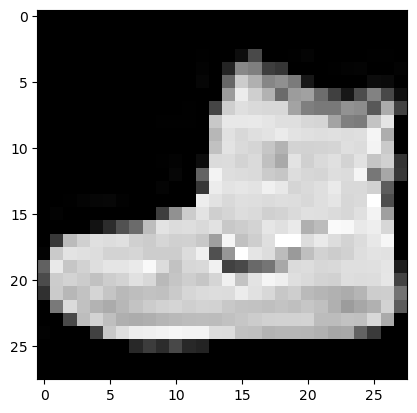

In [ ]:
# let's show it as image


%matplotlib inline
import matplotlib.pyplot as plt

sample = 0    #  change this number to select another sample


plt.imshow(x_train[sample], cmap='gray')

print("Image (#{}): Which is for label '{}'".format(sample,y_train[sample]))

### 3.3 Define CNN

In [ ]:
batch_size = 128

#### Let's create x (images) first.        

####  x must be 4D array

#### You must explicitly declare the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3.

In other words, we need to transform our dataset from the shape (n, rows, cols) to (n, rows, cols, depth).

#### Our MNIST images only have a depth of 1, but we must explicitly declare that.

In [ ]:
# Reshape tensor to any desired shape

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
x_train.dtype

dtype('uint8')

In [ ]:
# convert to float32 for normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

In [ ]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
Training samples: 60000
Test samples: 10000


####  Now we have x ready. Let's create y (class labels)

In [ ]:
print(y_train.shape)
print(y_train[:10])

(60000,)
[9 0 0 3 0 2 7 2 5 5]


#### For classification, TensorFlow requires y in one hot-encoded format.

In [ ]:
import tensorflow as tf

num_classes = 10

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

#### Build the model

In [ ]:
# Load modules
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


model = Sequential()

In [ ]:
img_rows = 28

img_cols = 28

input_shape = (img_rows, img_cols, 1)        # this is the shape of each sample

# For all define an input shape
# Shape of each input record
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)

Next, we can simply add more layers to our model

In [ ]:
# Note that number of filters from previous layer become the number of channels for current layer's input image.

model.add(MaxPooling2D(pool_size=(2, 2), strides=None))

model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=None))

model.add(Dropout(0.25))

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [ ]:

# Need to flatten the data before adding a dense layer
model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

# show not only log loss but also accuracy for each epoch using metrics=['accuracy']

# Set the loss, then optimizer, then learning rate)
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
import time

start_time = time.time()

# 100% of dataset


es = EarlyStopping(monitor='val_loss', mode='auto', min_delta=0.001, verbose=1, patience=3)
# auto : minimize loss or maximize accuracy.


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[es])

elapsed_time = time.time() - start_time

print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
469/469 - 8s - loss: 0.7989 - accuracy: 0.7080 - val_loss: 0.5061 - val_accuracy: 0.8067 - 8s/epoch - 17ms/step
Epoch 2/10
469/469 - 2s - loss: 0.5337 - accuracy: 0.8031 - val_loss: 0.4341 - val_accuracy: 0.8392 - 2s/epoch - 4ms/step
Epoch 3/10
469/469 - 2s - loss: 0.4687 - accuracy: 0.8280 - val_loss: 0.3958 - val_accuracy: 0.8531 - 2s/epoch - 4ms/step
Epoch 4/10
469/469 - 2s - loss: 0.4259 - accuracy: 0.8450 - val_loss: 0.3588 - val_accuracy: 0.8684 - 2s/epoch - 4ms/step
Epoch 5/10
469/469 - 2s - loss: 0.4012 - accuracy: 0.8536 - val_loss: 0.3425 - val_accuracy: 0.8717 - 2s/epoch - 4ms/step
Epoch 6/10
469/469 - 2s - loss: 0.3818 - accuracy: 0.8599 - val_loss: 0.3347 - val_accuracy: 0.8769 - 2s/epoch - 5ms/step
Epoch 7/10
469/469 - 2s - loss: 0.3675 - accuracy: 0.8651 - val_loss: 0.3183 - val_accuracy: 0.8799 - 2s/epoch - 4ms/step
Epoch 8/10
469/469 - 2s - loss: 0.3533 - accuracy: 0.8706 - val_loss: 0.3079 - val_accuracy: 0.8872 - 2s/epoch - 4ms/step
Epoch 9/10
469/469 - 2s

#### Evaluate Metrics using Sklearn

In [ ]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))


print(metrics.classification_report(y_true, pred))

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.895
Averaged F1: 0.8940025579303849
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.88      0.84      1000
           3       0.91      0.89      0.90      1000
           4       0.82      0.83      0.82      1000
           5       0.98      0.98      0.98      1000
           6       0.73      0.63      0.68      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.90      0.89     10000



## 4. Let's do transfer learning!

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


### We are going to use VGG16

https://neurohive.io/en/popular-networks/vgg16/

https://keras.io/applications/


VGG16 works on color images so we need to convert grey to RGB.

Examine to understand the  code in the following cell:

In [4]:
new_x_train = []

for image in x_train:
  # need to create "Color" image
  newImage = np.stack((image, image, image), axis=-1)
  new_x_train.append(newImage)



new_x_train= np.asarray(new_x_train)


In [5]:
new_x_train.shape

(60000, 28, 28, 3)

Now we get images with 3 channels!

In [6]:
new_x_test = []

for image in x_test:
  newImage = np.stack((image, image, image), axis=-1)
  new_x_test.append(newImage)


new_x_test = np.asarray(new_x_test)

In [7]:
new_x_test.shape

(10000, 28, 28, 3)

### Upsampling


#### VGG16 supports down to 32x32 images as an input.   However the fashion-mnist images are too low in terms of resolutions (28, 28) so we need to do upsampling


We use resize(), provided by scikit-image
https://scikit-image.org/

Check the RAM bar!  :)    You need at least 12 GB RAM to use the code!

In [8]:
# pip install scikit-image

from skimage.transform import resize


# Create tensor with the correct shape (64x64 with 3 channels)
# 60,000 all zero tensor
new_x_train_64x64 = np.zeros((60000, 64, 64, 3))

# Dump image into this all zero tensor
for x in range(len(new_x_train)):
  image = resize(new_x_train[x], (64, 64))       # resize also normalizes your image
  new_x_train_64x64[x] = image

# this process may take about a few minutes ....



new_x_test_64x64 = np.zeros((10000, 64, 64, 3))

for x in range(len(new_x_test)):
  image = resize(new_x_test[x], (64, 64))
  new_x_test_64x64[x] = image

# this process may take about a few minutes ....




In [9]:
new_x_train_64x64.shape

(60000, 64, 64, 3)

In [10]:
new_x_test_64x64.shape

(10000, 64, 64, 3)

In [10]:
y_train.shape

(60000,)

In [11]:
y_test.shape

(10000,)

In [11]:

# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#### Build model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.vgg16 import VGG16


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()


for layer in vgg_model.layers:
    model.add(layer)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [13]:
for layer in model.layers:
    layer.trainable = False



In [14]:
model.add(Flatten())

model.add(Dense(10, activation='softmax'))



In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')


model.fit(new_x_train_64x64[0:1000], y_train[0:1000],
          batch_size=128,
          epochs=10,    # change this to 100
          verbose=2,
          callbacks=[monitor],
          validation_data=(new_x_test_64x64[0:1000], y_test[0:1000]))

Epoch 1/10
8/8 - 10s - loss: 2.1501 - accuracy: 0.2820 - val_loss: 1.7442 - val_accuracy: 0.5380 - 10s/epoch - 1s/step
Epoch 2/10
8/8 - 1s - loss: 1.5305 - accuracy: 0.6380 - val_loss: 1.3054 - val_accuracy: 0.6770 - 628ms/epoch - 79ms/step
Epoch 3/10
8/8 - 1s - loss: 1.1432 - accuracy: 0.7290 - val_loss: 1.0312 - val_accuracy: 0.7380 - 955ms/epoch - 119ms/step
Epoch 4/10
8/8 - 1s - loss: 0.9180 - accuracy: 0.7710 - val_loss: 0.8809 - val_accuracy: 0.7570 - 665ms/epoch - 83ms/step
Epoch 5/10
8/8 - 1s - loss: 0.7847 - accuracy: 0.8040 - val_loss: 0.7821 - val_accuracy: 0.7750 - 975ms/epoch - 122ms/step
Epoch 6/10
8/8 - 1s - loss: 0.6949 - accuracy: 0.8160 - val_loss: 0.7244 - val_accuracy: 0.7940 - 974ms/epoch - 122ms/step
Epoch 7/10
8/8 - 1s - loss: 0.6338 - accuracy: 0.8250 - val_loss: 0.6821 - val_accuracy: 0.8010 - 624ms/epoch - 78ms/step
Epoch 8/10
8/8 - 1s - loss: 0.5888 - accuracy: 0.8420 - val_loss: 0.6456 - val_accuracy: 0.8110 - 641ms/epoch - 80ms/step
Epoch 9/10
8/8 - 1s - lo

In [16]:
from sklearn import metrics


y_true = np.argmax(y_test[0:1000],axis=1)

pred = model.predict(new_x_test_64x64[0:1000])
pred = np.argmax(pred,axis=1)

f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))


print(metrics.classification_report(y_true, pred))

32/32 [==============================] - 2s 31ms/step
Averaged F1: 0.8107896295339296
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       107
           1       0.97      0.94      0.96       105
           2       0.82      0.71      0.76       111
           3       0.70      0.76      0.73        93
           4       0.70      0.77      0.74       115
           5       0.89      0.85      0.87        87
           6       0.65      0.54      0.59        97
           7       0.83      0.91      0.86        95
           8       0.91      0.95      0.93        95
           9       0.93      0.87      0.90        95

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

